## AP-1 Design With Beluga/DeepSEA

In this first tutorial we will demonstrate how to use Ledidi to design edits when using a multi-task model such as DeepSEA/Beluga. Here, we will focus on the setting where you one want to make edits to effect one of the outputs and do not care too much about the other tasks.

The Beluga model we will use can be found on Kipoi: https://kipoi.org/models/DeepSEA/

The model is saved as a dictionary of weights and requires you to define the model architecture. This component is also taken from the Kipoi repo.

In [1]:
import torch
from torch import nn

class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input


class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))


class Beluga(nn.Module):
    def __init__(self):
        super(Beluga, self).__init__()
        self.model = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(4, 320, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(320, 320, (1, 8)),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.MaxPool2d((1, 4), (1, 4)),
                nn.Conv2d(320, 480, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(480, 480, (1, 8)),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.MaxPool2d((1, 4), (1, 4)),
                nn.Conv2d(480, 640, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(640, 640, (1, 8)),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Dropout(0.5),
                Lambda(lambda x: x.view(x.size(0), -1)),
                nn.Sequential(Lambda(lambda x: x.view(1, -1) if 1 == len(x.size()) else x), nn.Linear(67840, 2003)),
                nn.ReLU(),
                nn.Sequential(Lambda(lambda x: x.view(1, -1) if 1 == len(x.size()) else x), nn.Linear(2003, 2002)),
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)
    
model = Beluga()
model.load_state_dict(torch.load('beluga.pth'))
model = model.eval()

### Deleting AP-1

Now, we will load up a locus that was found to have AP-1 binding and is also correct predicted to have AP-1 binding. We will use bpnet-lite for some simple processing scripts but it is not a requirement of Ledidi. Any library for one-hot encoding sequences is fine as long as the shape matches what is expected by the model.

In [2]:
import numpy
import pyfaidx
from bpnetlite.io import one_hot_encode

chrom, start, end = 'chr2', 1930500, 1932500
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).unsqueeze(2)

y = model(X)[0, 309]
y

tensor(0.7741, grad_fn=<SelectBackward0>)

To confirm this is the case we can look at the attributions for the JunD in HepG2.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


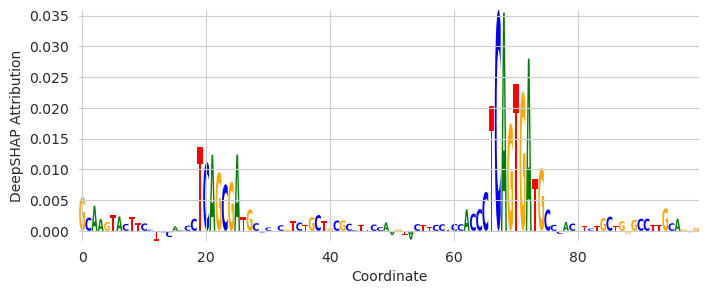

In [38]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

from captum.attr import DeepLiftShap

from bpnetlite.attributions import dinucleotide_shuffle
from bpnetlite.attributions import hypothetical_attributions
from bpnetlite.attributions import plot_attributions

references = dinucleotide_shuffle(X[0, :, 0], n_shuffles=20, random_state=0).unsqueeze(2)

ig = DeepLiftShap(model)
attr = ig.attribute(X, references, target=309, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0, :, 0]

plt.figure(figsize=(8, 3))
ax = plt.subplot(111)
plot_attributions(attr[:, 950:1050], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.show()

There are clearly two AP-1 binding sites hanging out together.

In [11]:
from ledidi import Ledidi

y_bar = torch.zeros(1, dtype=torch.float32)

designer = Ledidi(model, X.shape[1:], target=309, l=50, max_iter=1000, batch_size=1)
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=0.1514	total_loss=7.572
iter=0	input_loss= 1.0	output_loss=0.1497	total_loss=8.486	time=0.04968
iter=100	input_loss= 2.0	output_loss=0.1399	total_loss=8.996	time=10.73
iter=200	input_loss= 2.0	output_loss=0.1546	total_loss=9.732	time=10.72
iter=300	input_loss= 8.0	output_loss=0.1415	total_loss=15.07	time=10.74
iter=400	input_loss=15.0	output_loss=0.1201	total_loss=21.01	time=10.84
iter=500	input_loss=25.0	output_loss=0.05301	total_loss=27.65	time=10.94
iter=600	input_loss=20.0	output_loss=0.04426	total_loss=22.21	time=10.82
iter=700	input_loss=26.0	output_loss=0.05743	total_loss=28.87	time=10.67
iter=800	input_loss=32.0	output_loss=0.004286	total_loss=32.21	time=11.06
iter=900	input_loss=24.0	output_loss=0.04076	total_loss=26.04	time=10.63
iter=1000	input_loss=38.0	output_loss=0.01528	total_loss=38.76	time=10.83


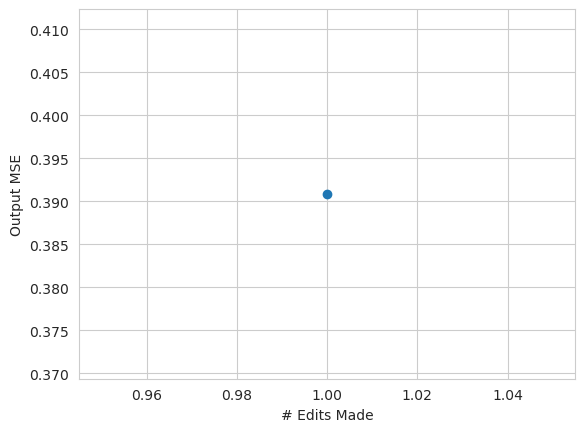

In [22]:
input_loss = torch.abs(X_hat - X).sum(axis=(1, 2, 3)).cpu().detach().numpy() // 2
output_loss = torch.square(model(X_hat)[:, 309] - y_bar).cpu().detach().numpy()

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, output_loss)
plt.xlabel("# Edits Made")
plt.ylabel("Output MSE")
plt.show()

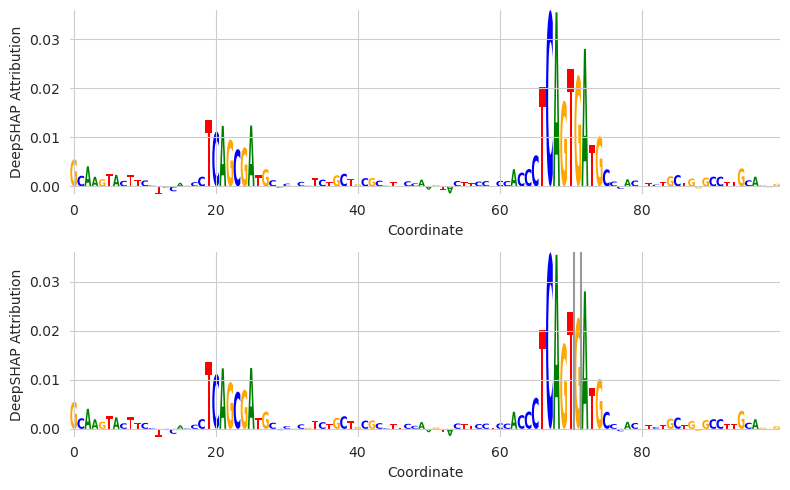

In [41]:
references = dinucleotide_shuffle(X_hat[best_idx, :, 0], n_shuffles=20, random_state=0).unsqueeze(2)

ig = DeepLiftShap(model)
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, target=309, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0, :, 0]

diff_idx = torch.where(torch.abs(X_hat - X)[best_idx, :, 0].sum(axis=0) != 0)[0][0]

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plot_attributions(attr[:, 950:1050], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plot_attributions(attr[:, 950:1050], ax=ax)
plt.plot([diff_idx-950-0.5, diff_idx-950-0.5], [0, attr.max()], color='0.6')
plt.plot([diff_idx+0.5-950, diff_idx+0.5-950], [0, attr.max()], color='0.6')
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

### Adding in a motif

In [42]:
chrom, start, end = 'chr2', 1870500, 1872500
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).unsqueeze(2)

y = model(X)[0, 309]
y

tensor(0.0014)

In [43]:
y_bar = torch.ones(1, dtype=torch.float32)

designer = Ledidi(model, X.shape[1:], target=309, l=50, max_iter=1000, batch_size=1)
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=0.9759	total_loss=48.8
iter=0	input_loss= 0.0	output_loss=0.9759	total_loss=48.8	time=0.04946
iter=100	input_loss= 0.0	output_loss=0.9759	total_loss=48.8	time=11.0
iter=200	input_loss= 0.0	output_loss=0.9759	total_loss=48.8	time=10.94
iter=300	input_loss= 6.0	output_loss=0.9681	total_loss=54.41	time=10.95
iter=400	input_loss=12.0	output_loss=0.9682	total_loss=60.41	time=11.12
iter=500	input_loss=37.0	output_loss=0.7846	total_loss=76.23	time=12.04
iter=600	input_loss=58.0	output_loss=0.3624	total_loss=76.12	time=10.8
iter=700	input_loss=48.0	output_loss=0.3458	total_loss=65.29	time=11.92
iter=800	input_loss=47.0	output_loss=0.3763	total_loss=65.81	time=11.6
iter=900	input_loss=44.0	output_loss=0.3196	total_loss=59.98	time=11.12
iter=1000	input_loss=43.0	output_loss=0.3739	total_loss=61.69	time=10.98


In [ ]:
references = dinucleotide_shuffle(X_hat[best_idx, :, 0], n_shuffles=20, random_state=0).unsqueeze(2)

ig = DeepLiftShap(model)
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, target=309, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0, :, 0]

diff_idx = torch.where(torch.abs(X_hat - X)[best_idx, :, 0].sum(axis=0) != 0)[0][0]

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plot_attributions(attr[:, 950:1050], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plot_attributions(attr[:, 950:1050], ax=ax)
plt.plot([diff_idx-950-0.5, diff_idx-950-0.5], [0, attr.max()], color='0.6')
plt.plot([diff_idx+0.5-950, diff_idx+0.5-950], [0, attr.max()], color='0.6')
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

### Controlled design: inputs

In [44]:
chrom, start, end = 'chr2', 1930500, 1932500
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).unsqueeze(2)

y = model(X)[0, 309]
y

tensor(0.7741)

In [58]:
y_bar = torch.ones(1, dtype=torch.float32)

designer = Ledidi(model, X.shape[1:], target=309, tau=10000, l=10, max_iter=1000, batch_size=1)
designer.weights.requires_grad = False
designer.weights[:, :950] = float("-inf")
designer.weights[:, 990:] = float("-inf")
designer.weights[X.type(torch.bool)] = 0
designer.weights.requires_grad = True

X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=0.5225	total_loss=5.225
iter=0	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=0.07582
iter=100	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.71
iter=200	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=12.93
iter=300	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.19
iter=400	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.42
iter=500	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.27
iter=600	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.26
iter=700	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.32
iter=800	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.27
iter=900	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.33
iter=1000	input_loss= 0.0	output_loss=0.5225	total_loss=5.225	time=11.28


In [48]:
designer.weights[X]

IndexError: tensors used as indices must be long, byte or bool tensors

In [53]:
designer.weights.requires_grad = False
designer.weights[X.type(torch.bool)] = 1

In [54]:
designer.weights

Parameter containing:
tensor([[[[nan, nan, nan,  ..., nan, 1., 1.]],

         [[1., nan, nan,  ..., 1., nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, 1., 1.,  ..., nan, nan, nan]]]])